In [ ]:
# ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# given by the assignment
def loadData():
    with np.load('notMNIST.npz') as data :
        Data, Target = data['images'], data['labels']
        posClass = 2
        negClass = 9
        dataIndx = (Target==posClass) + (Target==negClass)
        Data = Data[dataIndx]/255.
        Target = Target[dataIndx].reshape(-1, 1)
        Target[Target==posClass] = 1
        Target[Target==negClass] = 0
        np.random.seed(421)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data, Target = Data[randIndx], Target[randIndx]
        trainData, trainTarget = Data[:3500], Target[:3500]
        validData, validTarget = Data[3500:3600], Target[3500:3600]
        testData, testTarget = Data[3600:], Target[3600:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

# 0 Visualizing Dataset

It's always important to visualize the dataset to gain and understanding of what the model is trying to accomplish. This can help in the debugging phase. The shape of each data set is printed out as well as a random sample of the training data is plotted.

In [4]:
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
print(f"Training Data: {trainData.shape}\tTraining tagets: {trainTarget.shape}")
print(f"Validation Data: {validData.shape}\tValidation tagets: {validTarget.shape}")
print(f"Testing Data: {testData.shape}\tTesting tagets:{testTarget.shape}")

Training Data: (3500, 28, 28)	Training tagets: (3500, 1)
Validation Data: (100, 28, 28)	Validation tagets: (100, 1)
Testing Data: (145, 28, 28)	Testing tagets:(145, 1)


In [5]:
def plot(image, target, ax=None):
    ax = plt.gca() if ax == None else ax
    ax.imshow(image, cmap="hot")
    ax.set_title('J' if target == 0 else 'C')
    # targets are binary encoded 0 == 'J' and 1 == 'C'

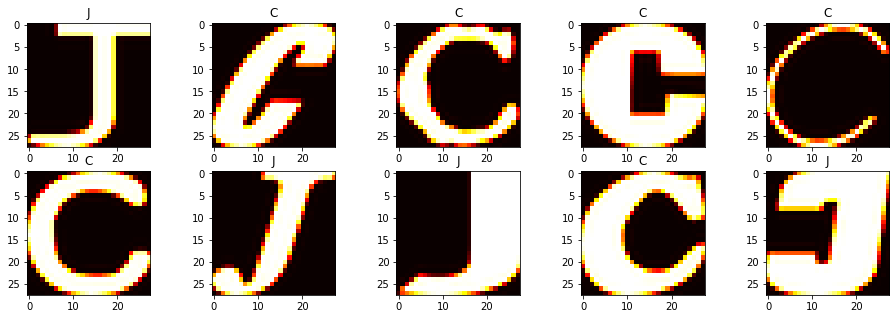

In [6]:
fig, axis = plt.subplots(2, 5, figsize=(16, 5))
for ax in axis.reshape(-1):
    r = np.random.randint(trainData.shape[0])
    plot(trainData[r], trainTarget[r], ax=ax)
plt.show()

Some useful functions that will be used throughout the assignment

In [7]:
def augment(X, w, b):
    # flatten X
    if len(X.shape) == 3:
        X = X.reshape(X.shape[0], -1)
    
    # insert 1's at position 0 along the columns
    X = np.insert(X, 0, 1, axis=1)
    
    # insert b at the front of W
    w = np.insert(w, 0, b, axis=0)
    
    return X, w

def get_zero_parameters():
    w = np.zeros(d)
    b = np.zeros(1)
    return w, b

def get_random_parameters():
    w = np.random.uniform(low=-1.0, high=1.0, size=(d,))
    b = np.random.uniform(low=-1.0, high=1.0, size=(1,))
    return w, b

In [8]:
def predict(w, b, X):
    X = X.reshape(X.shape[0], -1)
    return X.dot(w) + b

def accuracy(w, b, X, y):
    y = y.reshape(-1)
    y_pred = predict(w, b, X)
    y_pred = np.vectorize(lambda z: 1 if z > 0 else 0)(y_pred)
    return np.sum(y_pred == y) / y.shape[0]

def accuracy_with_predictions(y_pred, y):
    if y_pred.shape != y.shape:
        raise ValueError(f"prediction dimension {y_pred.shape} and label dimensions {y.shape} don't match")
    y_pred = np.vectorize(lambda z: 1 if z > 0 else 0)(y_pred)
    return np.sum(y_pred == y) / y.shape[0]

In [9]:
def plot_loss(x, train_loss=None, valid_loss=None, test_loss=None, title=None, ax=None):
    ax = plt.gca() if ax == None else ax
    if train_loss != None:
        ax.plot(x, train_loss, label="Training Loss")
    if valid_loss != None:
        ax.plot(x, valid_loss, label="Validation Loss")
    if test_loss != None:
        ax.plot(x, test_loss, label="Testing Loss")
    
    ax.set_title("Loss" if title == None else title)
    
    ax.set_xlabel("Iterations")
    ax.set_xlim(left=0)
    ax.set_ylabel("Loss")
    ax.set_ylim(bottom=0)
    ax.legend(loc="upper right")

def plot_accuracy(x, train_accuracy=None, valid_accuracy=None, test_accuracy=None, title=None, ax=None):
    ax = plt.gca() if ax == None else ax
    if train_accuracy != None:
        ax.plot(x, train_accuracy, label="Training Accuracy")
    if valid_accuracy != None:
        ax.plot(x, valid_accuracy, label="Validation Accuracy")
    if test_accuracy != None:
        ax.plot(x, test_accuracy, label="Testing Accuracy")
    
    ax.set_title("Accuracy" if title == None else title)

    ax.set_xlabel("Iterations")
    ax.set_xlim(left=0)
    ax.set_ylabel("Accuracy")
    ax.set_yticks(np.arange(0, 1.1, step=0.1))
    ax.grid(linestyle='-', axis='y')
    ax.legend(loc="lower right")

Some global variables that will be used throughout the assignment

In [10]:
VTDatasets = {"validData" : validData, "validTarget" : validTarget,
              "testData" : testData, "testTarget" : testTarget}

N = trainData.shape[0]
d = trainData.shape[1] * trainData.shape[2]

# 1 Linear Regression
### 1. Loss Function and Gradient

$$
\hat{y}^{(n)} = W^T \textbf{x}^{(n)} + b
$$

$$
\mathcal{L}_{MSE} = \frac{1}{N}\sum_{n=1}^N(\hat{y}^{(n)} - y^{(n)})^2 + \lambda \Vert W \Vert_2^2
$$

$$
\frac{\partial \mathcal{L}_{MSE}}{\partial b} = \frac{2}{N} \sum_{n=1}^N (\hat{y}^{(n)} - y^{(n)})
$$

$$
\frac{\partial \mathcal{L}_{MSE}}{\partial W} = \frac{2}{N} \ X^T \left ( \hat{
\textbf{y}} - \textbf{y} \right ) + \lambda W
$$


In [11]:
def MSE(w, b, X, y, reg):
    X = X.reshape(X.shape[0], -1)
    y = y.reshape(-1)
    return np.square(X.dot(w) + b - y).mean() + reg * np.square(w).sum()

def gradMSE(w, b, X, y, reg):
    X = X.reshape(X.shape[0], -1)
    y = y.reshape(-1)
    N = y.shape[0]
    
    w_grad = 2.0/N * X.T.dot(X.dot(w) + b - y) + reg * w
    b_grad = 2.0/N * np.sum(X.dot(w) + b - y)
    return w_grad, b_grad

### 2. Gradient Descent Implementation

In [12]:
def grad_descent_MSE(w, b, X, y, alpha, epochs, reg, error_tol=1e-7, 
                     validData=None, validTarget=None, testData=None, testTarget=None):
    train_loss, train_acc = [], []
    valid_loss, valid_acc = [], []
    test_loss, test_acc = [], []
    for i in range(epochs):
        grad_w, grad_b = gradMSE(w, b, X, y, reg)
        w -= alpha * grad_w
        b -= alpha * grad_b
        
        # Calculating Statistics
        train_loss.append( MSE(w, b, X, y, reg) )
        train_acc.append( accuracy(w, b, X, y) )

        if not validData is None and not validTarget is None:
            valid_loss.append( MSE(w, b, validData, validTarget, reg) )
            valid_acc.append( accuracy(w, b, validData, validTarget) )
        if not testData is None and not testTarget is None:
            test_loss.append( MSE(w, b, testData, testTarget, reg) )
            test_acc.append( accuracy(w, b, testData, testTarget) )

        # Check stopping condition
        if i > 1 and np.abs(train_loss[-2] - train_loss[-1]) <= error_tol:
            break

    statistics = (train_loss, train_acc)
    if not validData is None and not validTarget is None:
        statistics += (valid_loss, valid_acc, )
    if not testData is None and not testTarget is None:
        statistics += (test_loss, test_acc,)
    # Python 3.8 made this easier, but 3.7 you have to do this
    out = (w, b, *statistics)
    
    return out

### 3. Tuning the Learning Rate

alpha = 0.005
Training loss: 0.4199                    Training acc: 70.11%
Validation loss: 0.5428                  Validation acc: 71.00%
Testing loss: 0.7137                     Testing acc: 66.21%


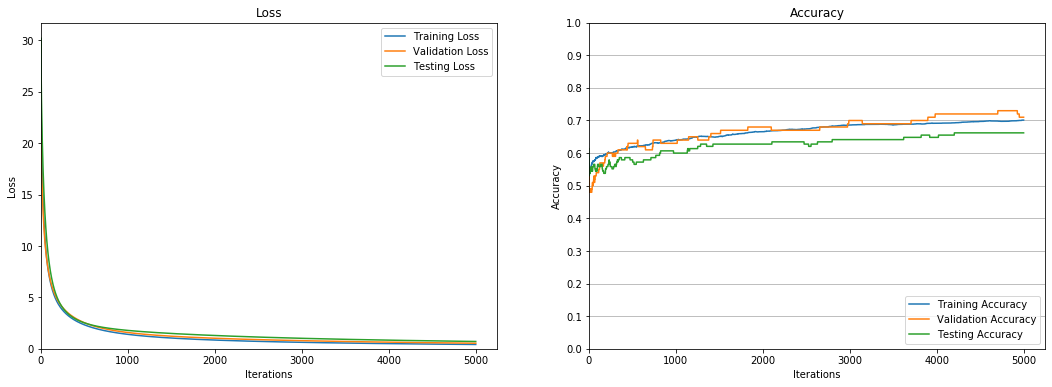

alpha = 0.001
Training loss: 1.4922                    Training acc: 62.17%
Validation loss: 2.1204                  Validation acc: 62.00%
Testing loss: 1.6711                     Testing acc: 63.45%


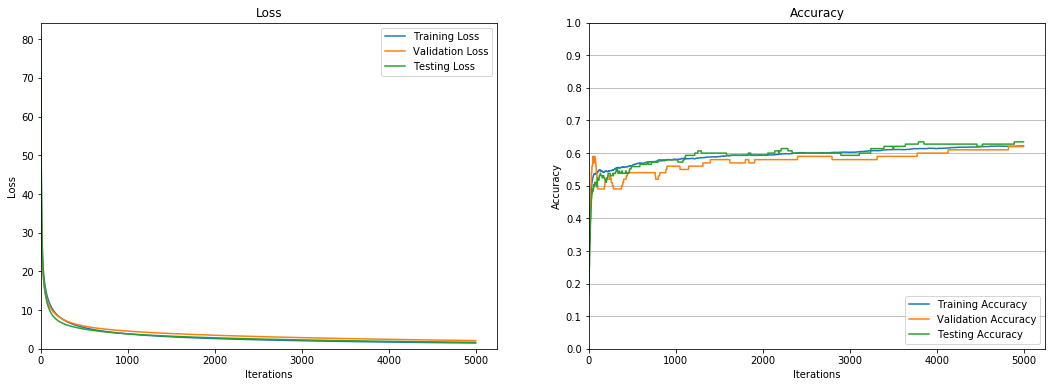

alpha = 0.0001
Training loss: 5.5281                    Training acc: 57.34%
Validation loss: 6.0496                  Validation acc: 55.00%
Testing loss: 7.3279                     Testing acc: 55.17%


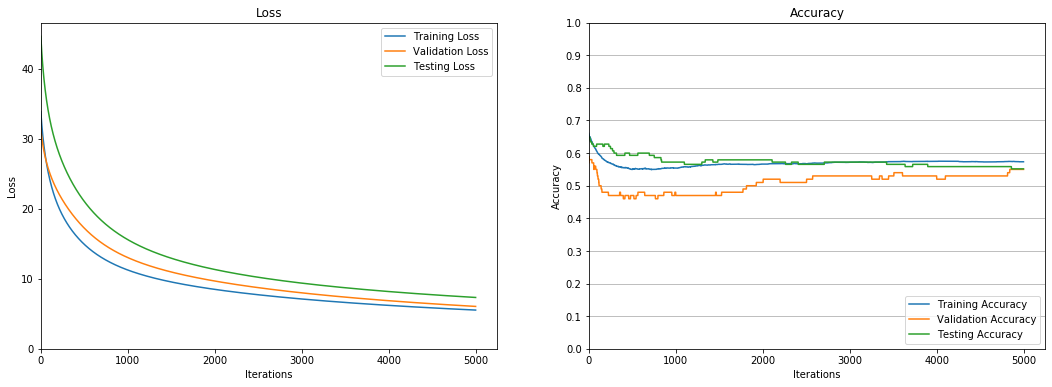

In [13]:
# Test your implementation of Gradient Descent with 5000 epochs and \lambda = 0. Investigate the
# impact of learning rate, \alpha = 0.005, 0.001, 0.0001 on the performance of your classifier. 
# Plot the training, validation and test losses.

for alpha in [0.005, 0.001, 0.0001]:
    
    print("alpha =", alpha)
    
    w, b = get_random_parameters()
    w, b, *statistics = grad_descent_MSE(w, b, trainData, trainTarget, 
                                         alpha=alpha, 
                                         epochs=5000, 
                                         reg=0, 
                                         **VTDatasets)
    train_loss, train_acc, valid_loss, valid_acc, test_loss, test_acc = statistics
    
    print(f"Training loss: {train_loss[-1]:.4f}{'':20s}Training acc: {train_acc[-1]*100:.2f}%")
    print(f"Validation loss: {valid_loss[-1]:.4f}{'':18s}Validation acc: {valid_acc[-1]*100:.2f}%")
    print(f"Testing loss: {test_loss[-1]:.4f}{'':21s}Testing acc: {test_acc[-1]*100:.2f}%")
    
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    plot_loss(np.arange(0, len(train_loss), 1), train_loss, valid_loss, test_loss, ax=ax[0])
    plot_accuracy(np.arange(0, len(train_loss), 1), train_acc, valid_acc, test_acc, ax=ax[1])
    plt.show()
    plt.close()

### 4. Generalization

regularization = 0.001
Training loss: 0.5822	Training acc: 69.54%
Validation loss: 0.8218	Validation acc: 61.00%
Testing loss: 0.8229	Testing acc: 69.66%


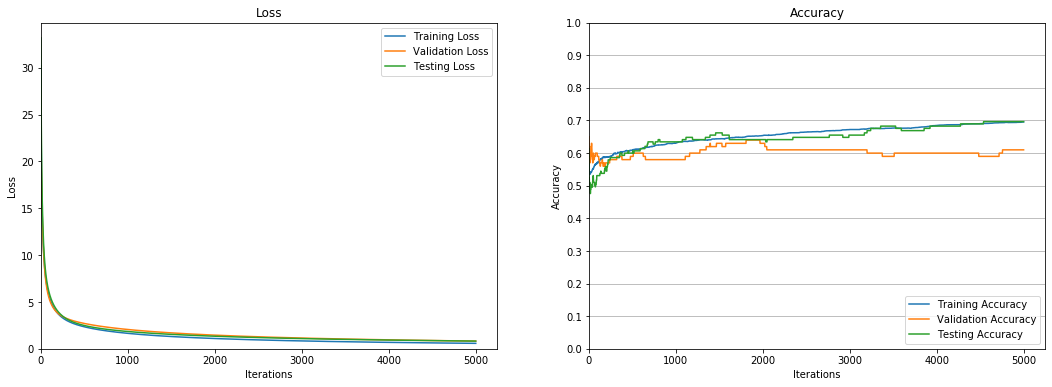

regularization = 0.1
Training loss: 0.1332	Training acc: 68.60%
Validation loss: 0.1355	Validation acc: 65.00%
Testing loss: 0.1393	Testing acc: 64.14%


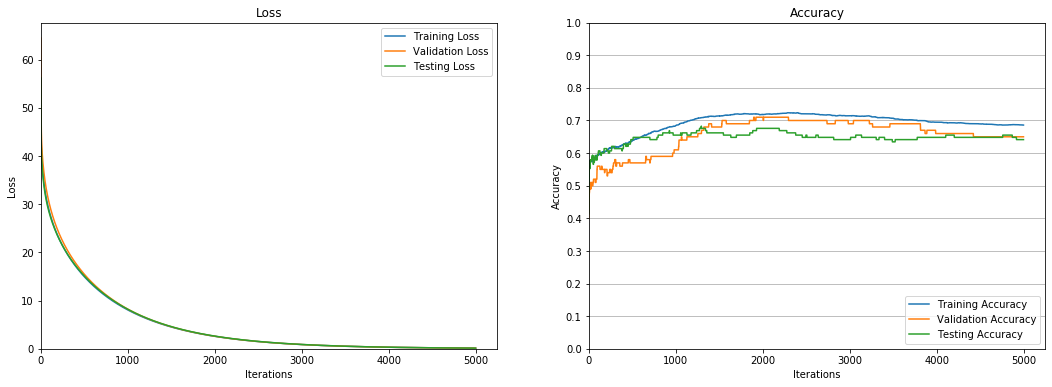

regularization = 0.5
Training loss: 0.0416	Training acc: 65.94%
Validation loss: 0.0451	Validation acc: 66.00%
Testing loss: 0.0442	Testing acc: 61.38%


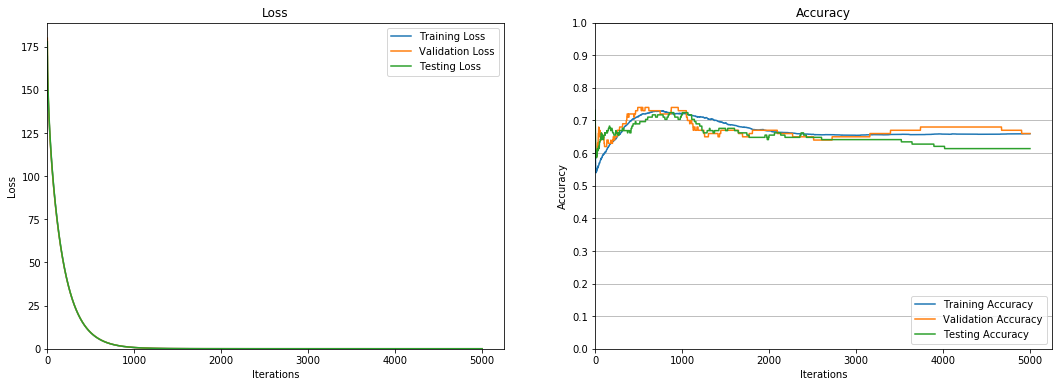

In [14]:
# Investigate impact by modifying the regularization parameter, \lambda = {0.001, 0.1, 0.5}. 
# Plot the training, validation and test loss for \alpha = 0:005 and report the final training, 
# validation and test accuracy of your classifier.

for reg in [0.001, 0.1, 0.5]:
    
    print("regularization =", reg)
    
    w, b = get_random_parameters()
    w, b, *statistics = grad_descent_MSE(w, b, trainData, trainTarget, 
                                         alpha=0.005, 
                                         epochs=5000, 
                                         reg=reg, 
                                         **VTDatasets)
    train_loss, train_acc, valid_loss, valid_acc, test_loss, test_acc = statistics
    
    print(f"Training loss: {train_loss[-1]:.4f}{'':.20s}\tTraining acc: {train_acc[-1]*100:.2f}%")
    print(f"Validation loss: {valid_loss[-1]:.4f}\tValidation acc: {valid_acc[-1]*100:.2f}%")
    print(f"Testing loss: {test_loss[-1]:.4f}\tTesting acc: {test_acc[-1]*100:.2f}%")
    
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    plot_loss(np.arange(0, len(train_loss), 1), train_loss, valid_loss, test_loss, ax=ax[0])
    plot_accuracy(np.arange(0, len(train_loss), 1), train_acc, valid_acc, test_acc, ax=ax[1])
    plt.show()
    plt.close()

### 5. Comparing Batch GD with normal equation

In [15]:
def least_squares(X, y):
    N = X.shape[0]
    d = X.shape[1] * X.shape[2]
    X = X.reshape(X.shape[0], -1)
    X = np.insert(X, 0, 1, axis=1)
    y = y.reshape(-1)
    
    # overparameterized (deep learning)
    if N < d:
        w_aug = X.T @ np.linalg.inv( X @ X.T ) @ y
    
    # underparameterized (typical case)
    else:
        w_aug = np.linalg.inv( X.T @ X ) @ X.T @ y
    
    return w_aug[1:], w_aug[0]

In [16]:
# compare above to gradient descent solution
w_LS, b_LS = least_squares(trainData, trainTarget)

loss = MSE(w_LS, b_LS, trainData, trainTarget, 0)
acc = accuracy(w_LS, b_LS, trainData, trainTarget)
print(f"Least Squares Training loss: {loss:.4f}\tLeast Squares Training acc: {100*acc:.2f}%")
loss = MSE(w_LS, b_LS, validData, validTarget, 0)
acc = accuracy(w_LS, b_LS, validData, validTarget)
print(f"Least Squares Validation loss: {loss:.4f}\tLeast Squares Validation acc: {100*acc:.2f}%")
loss = MSE(w_LS, b_LS, testData, testTarget, 0)
acc = accuracy(w_LS, b_LS, testData, testTarget)
print(f"Least Squares Testing loss: {loss:.4f}\tLeast Squares Testing acc: {100*acc:.2f}%")

Least Squares Training loss: 0.0187	Least Squares Training acc: 71.29%
Least Squares Validation loss: 0.0476	Least Squares Validation acc: 69.00%
Least Squares Testing loss: 0.0570	Least Squares Testing acc: 66.90%


With the analytical solution, the training loss achieved with the analytical equation is 0.0187 with a training accuracy of 71.29%. The training loss and accuracies for batch gradient descent were respectively 0.6918 and 67.97%. From the values, we see that the analytical solution performed better. However, computing it grows increasingly difficult with the size of the problem. As the problem scales, batch gradient descent allows for faster convergence with comparable accuracies.

# 2 Logistic Regression
## 2.1 Binary cross-entropy loss
### 1. Loss Function and Gradient

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

$$
\hat{y}^{(n)} = \sigma(W^T\textbf{x}^{(n)} + b)
$$

$$
\mathcal{L}_{CE} = \frac{1}{N}\sum_{n=1}^{N} \left [ -y^{(n)} \log(\hat{y}^{(n)}) -(1- y^{(n)}) \log (1 - \hat{y}^{(n)} ) \right ] + \frac{\lambda}{2} \Vert W \Vert^2_2
$$

$$
\frac{\partial \mathcal{L}_{CE}}{\partial b} = \frac{1}{N} \sum_{n=1}^{N} \left [ \hat{y}^{(n)} - y^{(n)} \right ]
$$

$$
\frac{\partial \mathcal{L}_{CE}}{\partial W} = \frac{1}{N} \sum_{n=1}^{N} \left [ (\hat{y}^{(n)} - y^{(n)}) \ \textbf{x}^{(n)} \right ] + \lambda W
$$

In [17]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))
    
def crossEntropyLoss(w, b, X, y, reg):    
    X, w = augment(X, w, b)
    y = y.reshape(-1)
    N = y.shape[0]
    
    y_hat = sigmoid(X.dot(w))
    
    return 1.0/N * (-y.dot(np.log(y_hat+1e-20)) - (1 - y).dot(np.log(1 - y_hat+1e-20))) + reg/2.0 * np.square(w[1:]).sum()
    
def gradCE(w, b, X, y, reg):
    X, w = augment(X, w, b)
    y = y.reshape(-1)
    N = y.shape[0]
    
    y_hat = sigmoid(X.dot(w))
    
    grad = 1.0 /N * X.T.dot(y_hat - y) + reg * w
    
    return grad[1:], grad[0] - reg * w[0]

### 2. Learning

In [18]:
def grad_descent(w, b, X, y, alpha, epochs, reg, error_tol=1e-7, lossType="MSE", 
                 validData=None, validTarget=None, testData=None, testTarget=None):
    loss_func, grad_func = None, None
    if lossType == "MSE":
        loss_func, grad_func = MSE, gradMSE
    elif lossType == "CE":
        loss_func, grad_func = crossEntropyLoss, gradCE
    else:
        raise ValueError("Variable 'lossType' must be either 'MSE' or 'CE'.")
    
    train_loss, train_acc = [], []
    valid_loss, valid_acc = [], []
    test_loss, test_acc = [], []
    printing = False
    for i in range(epochs):
        grad_w, grad_b = grad_func(w, b, X, y, reg)
        w -= alpha * grad_w
        b -= alpha * grad_b

        # Calculating Statistics
        train_loss.append(loss_func(w, b, X, y, reg))
        train_acc.append(accuracy(w, b, X, y))

        if not validData is None and not validTarget is None:
            valid_loss.append(loss_func(w, b, validData, validTarget, reg))
            valid_acc.append(accuracy(w, b, validData, validTarget))
        if not testData is None and not testTarget is None:
            test_loss.append(loss_func(w, b, testData, testTarget, reg))
            test_acc.append(accuracy(w, b, testData, testTarget))

        # Check stopping condition
        if i > 1 and np.abs(train_loss[-2] - train_loss[-1]) <= error_tol:
            break

    statistics = (train_loss, train_acc)
    if not validData is None and not validTarget is None:
        statistics += (valid_loss, valid_acc,)
    if not testData is None and not testTarget is None:
        statistics += (test_loss, test_acc,)
    out = (w, b, *statistics)

    return out

Training loss: 0.1992	Training acc: 98.06%
Validation loss: 0.2082	Validation acc: 98.00%
Testing loss: 0.2055	Testing acc: 97.93%


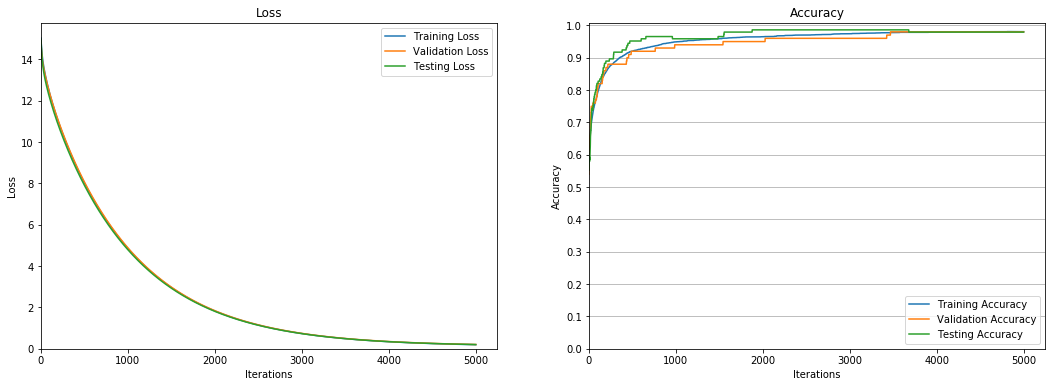

In [19]:
w, b = get_random_parameters()
w, b, *statistics = grad_descent(w, b, trainData, trainTarget, 
                                 alpha=0.005, 
                                 epochs=5000, 
                                 reg=0.1,
                                 lossType='CE',
                                 **VTDatasets)
train_loss, train_acc, valid_loss, valid_acc, test_loss, test_acc = statistics

print(f"Training loss: {train_loss[-1]:.4f}{'':.20s}\tTraining acc: {train_acc[-1]*100:.2f}%")
print(f"Validation loss: {valid_loss[-1]:.4f}\tValidation acc: {valid_acc[-1]*100:.2f}%")
print(f"Testing loss: {test_loss[-1]:.4f}\tTesting acc: {test_acc[-1]*100:.2f}%")

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
plot_loss(np.arange(0, len(train_loss), 1), train_loss, valid_loss, test_loss, ax=ax[0])
plot_accuracy(np.arange(0, len(train_loss), 1), train_acc, valid_acc, test_acc, ax=ax[1])
plt.show()

### 3. Comparision to Linear Regression

Linear Regression
Training loss: 0.4194	Training acc: 70.69%
Validation loss: 0.5375	Validation acc: 74.00%
Testing loss: 0.4956	Testing acc: 68.97%


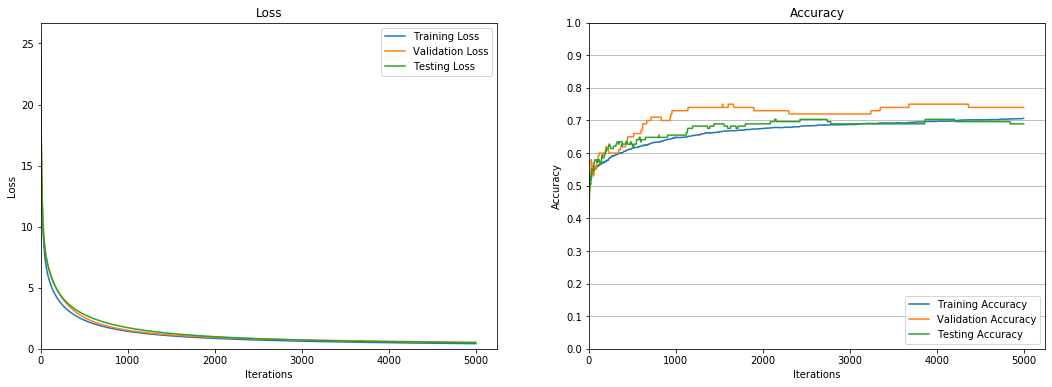

Logistic Regression
Training loss: 0.0553	Training acc: 98.14%
Validation loss: 0.0647	Validation acc: 97.00%
Testing loss: 0.0847	Testing acc: 97.93%


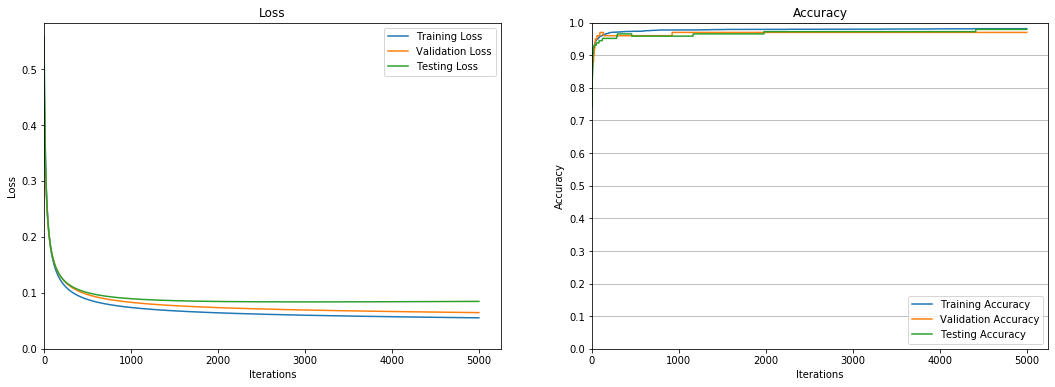

In [20]:
# For zero weight decay, learning rate of 0.005 and 5000 epochs, 
# plot the training cross entropy loss and MSE loss for 
# logistic regression and linear regression respectively.
# Comment on the effect of cross-entropy loss convergence behaviour.

w, b = get_random_parameters()

# Linear Regresesion
print("Linear Regression")
w_lin, b_lin, *statistics = grad_descent(w, b, trainData, trainTarget, 
                                         alpha=0.005, 
                                         epochs=5000, 
                                         reg=0,
                                         lossType='MSE',
                                         **VTDatasets)
train_loss, train_acc, valid_loss, valid_acc, test_loss, test_acc = statistics

print(f"Training loss: {train_loss[-1]:.4f}{'':.20s}\tTraining acc: {train_acc[-1]*100:.2f}%")
print(f"Validation loss: {valid_loss[-1]:.4f}\tValidation acc: {valid_acc[-1]*100:.2f}%")
print(f"Testing loss: {test_loss[-1]:.4f}\tTesting acc: {test_acc[-1]*100:.2f}%")

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
plot_loss(np.arange(0, len(train_loss), 1), train_loss, valid_loss, test_loss, ax=ax[0])
plot_accuracy(np.arange(0, len(train_loss), 1), train_acc, valid_acc, test_acc, ax=ax[1])
plt.show()


# Logistic Regression
print("Logistic Regression")
w_log, b_log, *statistics = grad_descent(w, b, trainData, trainTarget, 
                                         alpha=0.005, 
                                         epochs=5000, 
                                         reg=0,
                                         lossType='CE',
                                         **VTDatasets)
train_loss, train_acc, valid_loss, valid_acc, test_loss, test_acc = statistics

print(f"Training loss: {train_loss[-1]:.4f}{'':.20s}\tTraining acc: {train_acc[-1]*100:.2f}%")
print(f"Validation loss: {valid_loss[-1]:.4f}\tValidation acc: {valid_acc[-1]*100:.2f}%")
print(f"Testing loss: {test_loss[-1]:.4f}\tTesting acc: {test_acc[-1]*100:.2f}%")

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
plot_loss(np.arange(0, len(train_loss), 1), train_loss, valid_loss, test_loss, ax=ax[0])
plot_accuracy(np.arange(0, len(train_loss), 1), train_acc, valid_acc, test_acc, ax=ax[1])
plt.show()

# Sandra

# 3 Batch Gradient Descent vs. SGD and Adam
## 3.1 SGD
### 1. Building the Computational Graph

In [21]:
def buildGraph(alpha, reg=0, beta1=None, beta2=None, epsilon=None, loss="MSE", seed=None):
    
    kwargs = {}
    if beta1 != None:
        kwargs["beta1"] = beta1
    if beta2 != None:
        kwargs["beta2"] = beta2
    if epsilon != None:
        kwargs["epsilon"] = epsilon
    
    # Initialize weight and bias tensors
    tf.set_random_seed(seed)
    tf.compat.v1.set_random_seed(seed)
    tf.compat.v1.disable_eager_execution()

    # Getting small random initial values for weights and bias
    w = tf.truncated_normal([d, 1], stddev=0.5)
    b = tf.truncated_normal([1, 1], stddev=0.5)

    # Converting into tensorflow Variable objects
    w = tf.Variable(w, name="weights")
    b = tf.Variable(b, name="bias")

    # tensorflow objects for data
    X = tf.placeholder(tf.float32, (None, d))
    y = tf.placeholder(tf.float32, (None, 1))

    y_pred = None
    cost = None
    if loss == "MSE":
        y_pred = tf.matmul(X, w) + b
        cost = tf.losses.mean_squared_error(y, y_pred) + reg * tf.norm(w)**2
    elif loss == "CE":
        y_pred = tf.sigmoid(tf.matmul(X, w) + b)
        cost = tf.losses.sigmoid_cross_entropy(y, y_pred)
    else:
        raise ValueError("Variable 'lossType' must be either 'MSE' or 'CE'.")

    opt = tf.train.AdamOptimizer(learning_rate=alpha, **kwargs)
    opt_op = opt.minimize(cost)

    return w, b, X, y, y_pred, cost, opt_op

# test call to see output
# buildGraph(trainData, trainTarget, beta1=0.95, beta2=0.99, epsilon=10^-5, alpha=0.001)

### 2. Implementing Stochastic Gradient Descent

In [22]:
class BatchLoader(object):

    def __init__(self, data, batch_size=None, randomize=True, drop_last=False, seed=None):
    
        # error checking
        if len(data) > 1:
            for i in range(len(data)-1):
                if data[i].shape[0] != data[i+1].shape[0]:
                    raise ValueError("All inputs must have the same number of elements")
    
        self.data = data if type(data) == tuple else (data, )
        self.N = data[0].shape[0]
        self.batch_size = batch_size if batch_size != None else self.N
        self.drop_last = drop_last

        # shuffling data
        if randomize:
            indices = np.arange(self.N)
            np.random.seed(seed)
            np.random.shuffle(indices)
            self.data = tuple([d[indices] for d in self.data])
    
        self.index = 0 

    def __iter__(self):
        return self
    
    def __next__(self):
    
        # stop condition
        if self.index >= self.N:
            self.index = 0          # resetting index for next iteration
            raise StopIteration

        # iterating
        self.index += self.batch_size
    
        if self.index > self.N:
            if self.drop_last:
                self.index = 0      # resetting index for next iteration
                raise StopIteration
            else:
                return tuple([ d[self.index - self.batch_size: ] for d in self.data ])
        else:
            return tuple([ d[self.index - self.batch_size: self.index] for d in self.data ])

In [32]:
def SGD(X, y, alpha, epochs, reg, error_tol=1e-7, lossType="MSE",
              batch_size=500, randomize=True, beta1=None, beta2=None, epsilon=None,
              validData=None, validTarget=None, testData=None, testTarget=None):
    
    X = X.reshape(X.shape[0], -1)
    if not validData is None:
        validData = validData.reshape(validData.shape[0], -1)
    if not testData is None:
        testData = testData.reshape(testData.shape[0], -1)
    
    train_loss, train_acc = [], []
    valid_loss, valid_acc = [], []
    test_loss, test_acc = [], []
    printing = False
    
    running_loss = 0.0
    running_acc = 0.0
    
    w, b, X_tf, y_tf, y_pred_tf, cost, optimizer = buildGraph(alpha=alpha, reg=reg, loss=lossType,
                                                              beta1=beta1, beta2=beta2, epsilon=epsilon)
    batch_iter = BatchLoader((X, y), batch_size=500, randomize=False)

    init = tf.initialize_all_variables()
    with tf.Session() as sess:
        sess.run(init)
        for e in range(epochs):
            for X_batch, y_batch in batch_iter:
                # updating the weights
                sess.run(optimizer, feed_dict={X_tf: X_batch, y_tf: y_batch})
                
                # getting the cost
                running_loss += sess.run(cost, feed_dict={X_tf: X_batch, y_tf: y_batch}) * X_batch.shape[0]
                y_pred = sess.run(y_pred_tf, feed_dict={X_tf: X_batch, y_tf: y_batch})
                running_acc += accuracy_with_predictions(y_pred.flatten(), y_batch.flatten()) * y_batch.shape[0]
                
            else:
                # Calculating Statistics
                train_loss.append(running_loss / X.shape[0])
                train_acc.append(running_acc / X.shape[0])
                running_loss = 0.0
                running_acc = 0.0

                if not validData is None and not validTarget is None:
                    valid_loss.append(sess.run(cost, feed_dict={X_tf: validData, y_tf: validTarget}))
                    y_pred = sess.run(y_pred_tf, feed_dict={X_tf: validData, y_tf: validTarget})
                    valid_acc.append(accuracy_with_predictions(y_pred.flatten(), validTarget.flatten()))
                if not testData is None and not testTarget is None:
                    test_loss.append(sess.run(cost, feed_dict={X_tf: testData, y_tf: testTarget}))
                    y_pred = sess.run(y_pred_tf, feed_dict={X_tf: testData, y_tf: testTarget})
                    test_acc.append(accuracy_with_predictions(y_pred.flatten(), testTarget.flatten()))

                continue
            break

    statistics = (train_loss, train_acc)
    if not validData is None and not validTarget is None:
        statistics += (valid_loss, valid_acc,)
    if not testData is None and not testTarget is None:
        statistics += (test_loss, test_acc,)
    out = (w, b, *statistics)
    
    return out

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


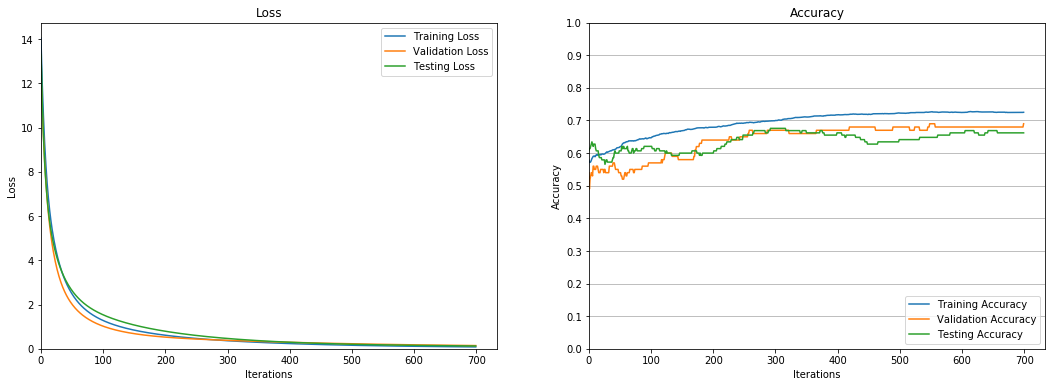

In [24]:
# Implement the SGD algorithm for a minibatch size of 500
# optimizing over 700 epochs, minimizing the MSE (you will repeat this for the CE later).
# Calculate the total number of batches required by dividing the number
# of training instances by the minibatch size. After each epoch you will need to reshuffle the
# training data and start sampling from the beginning again. Initially, set \lambda = 0 and continue
# to use the same \alpha value (i.e. 0.001). After each epoch, store the training, validation and test
# losses and accuracies. Use these to plot the loss and accuracy curves.

w, b, *statistics = SGD(trainData, trainTarget, 
                        alpha=0.001, 
                        epochs=700, 
                        reg=0,
                        lossType='MSE',
                        batch_size=500,
                        **VTDatasets)
train_loss, train_acc, valid_loss, valid_acc, test_loss, test_acc = statistics

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
plot_loss(np.arange(0, len(train_loss), 1), train_loss, valid_loss, test_loss, ax=ax[0])
plot_accuracy(np.arange(0, len(train_loss), 1), train_acc, valid_acc, test_acc, ax=ax[1])
plt.show()

### 3. Batch Size Investigation

batch size = 100
Training loss: 0.1042                    Training acc: 72.31%
Validation loss: 0.1978                  Validation acc: 68.00%
Testing loss: 0.1457                     Testing acc: 68.97%


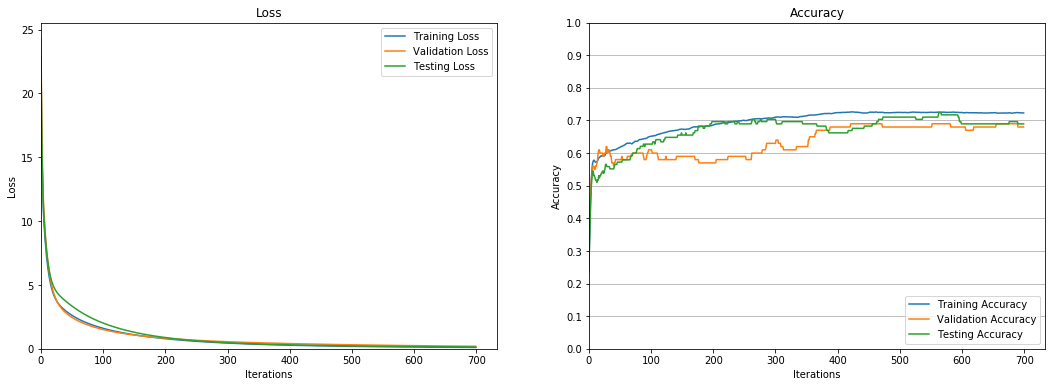

batch size = 700
Training loss: 0.1165                    Training acc: 72.00%
Validation loss: 0.1968                  Validation acc: 74.00%
Testing loss: 0.1697                     Testing acc: 68.28%


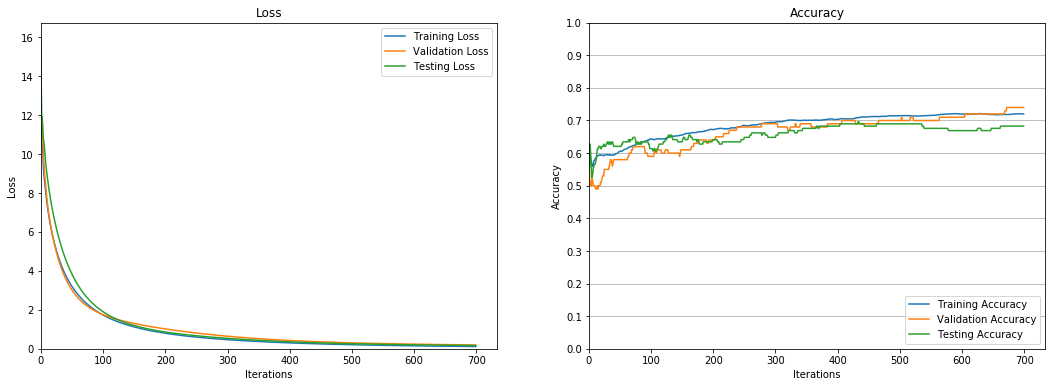

batch size = 1750
Training loss: 0.1658                    Training acc: 71.66%
Validation loss: 0.2210                  Validation acc: 66.00%
Testing loss: 0.2154                     Testing acc: 73.10%


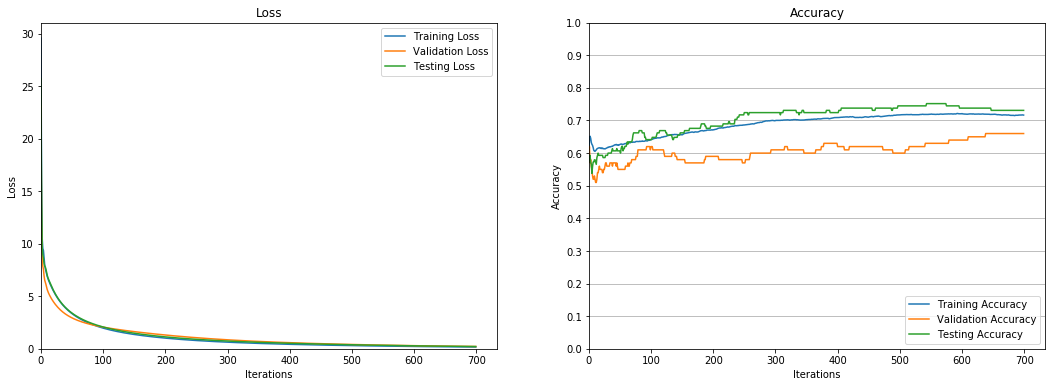

In [25]:
for batch_size in [100, 700, 1750]:
    
    print("batch size =", batch_size)
    
    w, b, *statistics = SGD(trainData, trainTarget, 
                            alpha=0.001, 
                            epochs=700, 
                            reg=0,
                            lossType='CE',
                            batch_size=500,
                            **VTDatasets)
    train_loss, train_acc, valid_loss, valid_acc, test_loss, test_acc = statistics
    
    print(f"Training loss: {train_loss[-1]:.4f}{'':20s}Training acc: {train_acc[-1]*100:.2f}%")
    print(f"Validation loss: {valid_loss[-1]:.4f}{'':18s}Validation acc: {valid_acc[-1]*100:.2f}%")
    print(f"Testing loss: {test_loss[-1]:.4f}{'':21s}Testing acc: {test_acc[-1]*100:.2f}%")
    
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    plot_loss(np.arange(0, len(train_loss), 1), train_loss, valid_loss, test_loss, ax=ax[0])
    plot_accuracy(np.arange(0, len(train_loss), 1), train_acc, valid_acc, test_acc, ax=ax[1])
    plt.show()
    plt.close()

### 4. Hyperparameter Investigation

beta1: 0.95	beta2: 0.99	epsilon: 1e-09
Training loss: 0.0445                    Training acc: 71.51%
Validation loss: 0.0974                  Validation acc: 72.00%
Testing loss: 0.0806                     Testing acc: 66.21%


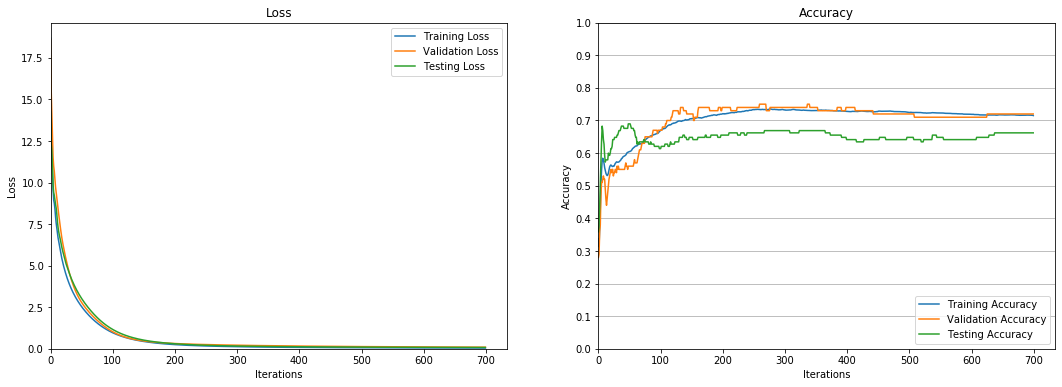

beta1: 0.95	beta2: 0.99	epsilon: 0.0001
Training loss: 0.0545                    Training acc: 72.03%
Validation loss: 0.1464                  Validation acc: 68.00%
Testing loss: 0.0937                     Testing acc: 70.34%


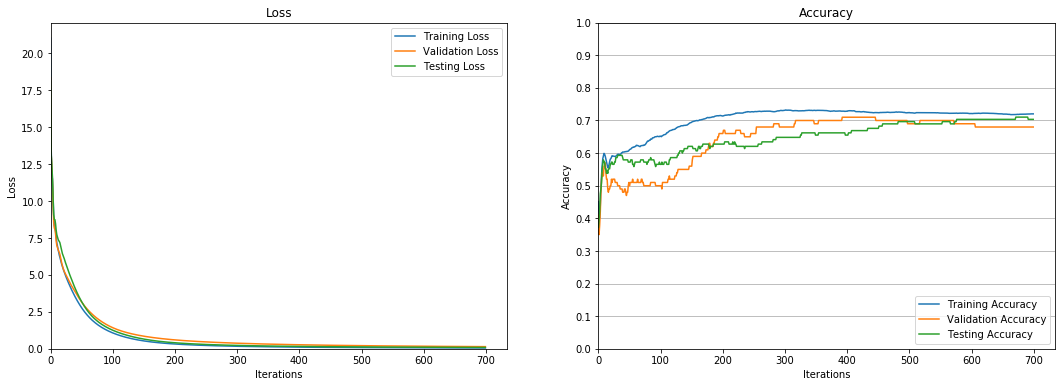

beta1: 0.95	beta2: 0.9999	epsilon: 1e-09
Training loss: 0.1769                    Training acc: 71.77%
Validation loss: 0.2318                  Validation acc: 72.00%
Testing loss: 0.2554                     Testing acc: 68.97%


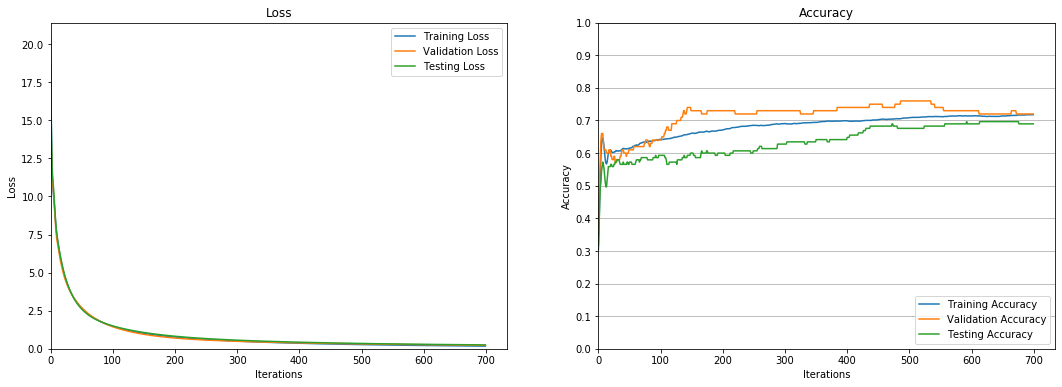

beta1: 0.95	beta2: 0.9999	epsilon: 0.0001
Training loss: 0.2748                    Training acc: 70.83%
Validation loss: 0.5444                  Validation acc: 67.00%
Testing loss: 0.3462                     Testing acc: 70.34%


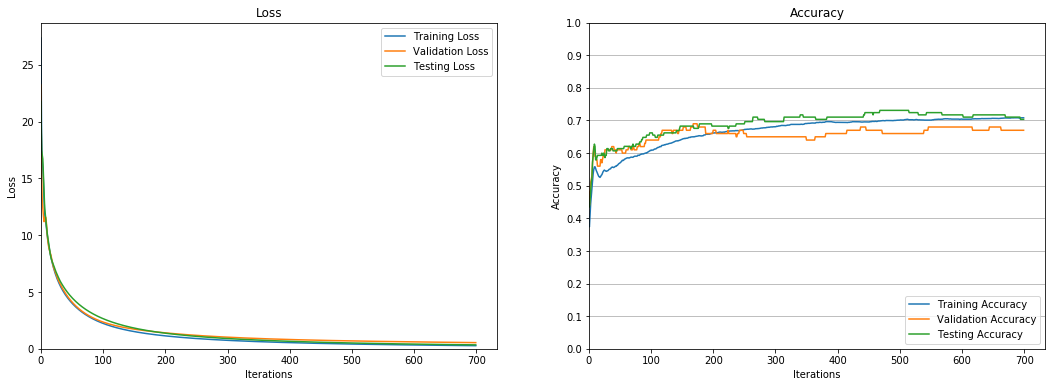

beta1: 0.99	beta2: 0.99	epsilon: 1e-09
Training loss: 0.0323                    Training acc: 72.11%
Validation loss: 0.0793                  Validation acc: 74.00%
Testing loss: 0.0939                     Testing acc: 64.14%


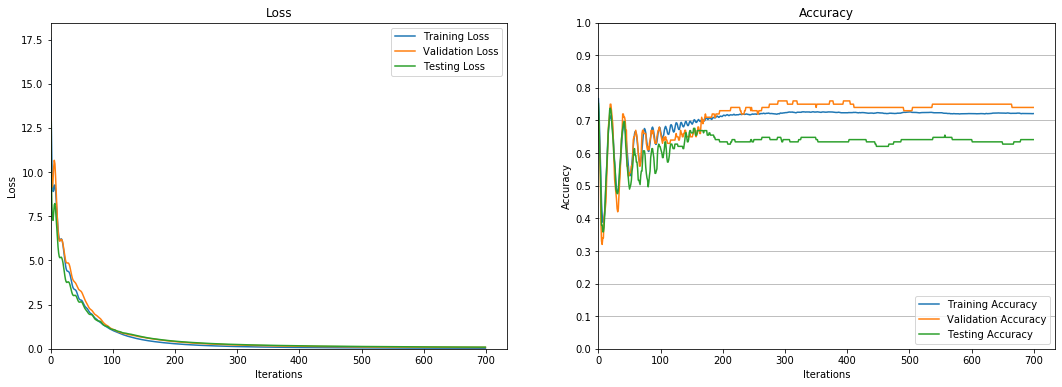

beta1: 0.99	beta2: 0.99	epsilon: 0.0001
Training loss: 0.0462                    Training acc: 71.94%
Validation loss: 0.0798                  Validation acc: 76.00%
Testing loss: 0.0848                     Testing acc: 71.03%


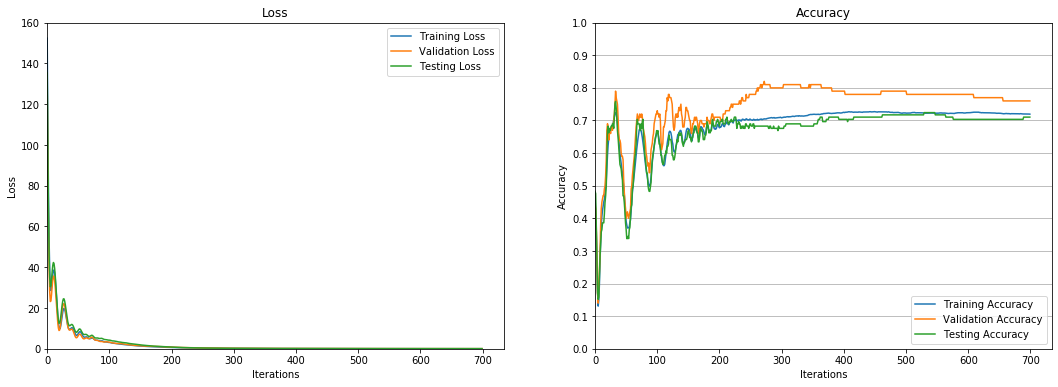

beta1: 0.99	beta2: 0.9999	epsilon: 1e-09
Training loss: 0.6918                    Training acc: 68.20%
Validation loss: 1.0152                  Validation acc: 57.00%
Testing loss: 0.9203                     Testing acc: 73.79%


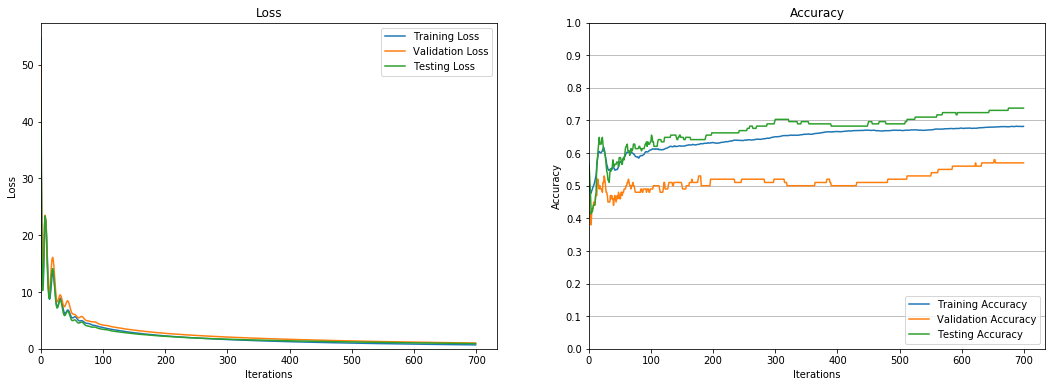

beta1: 0.99	beta2: 0.9999	epsilon: 0.0001
Training loss: 0.4344                    Training acc: 70.43%
Validation loss: 0.7616                  Validation acc: 66.00%
Testing loss: 0.7112                     Testing acc: 66.90%


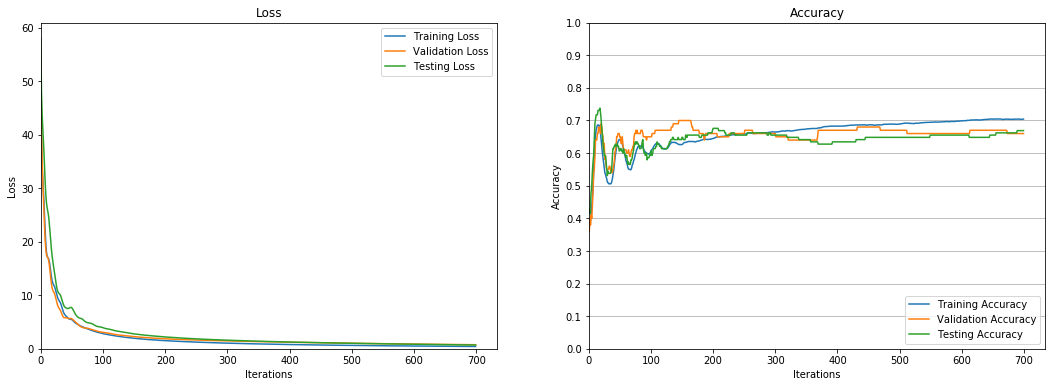

In [26]:
for beta1 in [0.95, 0.99]:
    for beta2 in [0.99, 0.9999]:
        for epsilon in [1e-9, 1e-4]:
            
            print(f"beta1: {beta1}\tbeta2: {beta2}\tepsilon: {epsilon}")
            
            w, b, *statistics = SGD(trainData, trainTarget, 
                                    alpha=0.001, 
                                    epochs=700, 
                                    reg=0,
                                    lossType='MSE',
                                    batch_size=500,
                                    beta1=beta1, beta2=beta2, epsilon=epsilon,
                                    **VTDatasets)
            
            train_loss, train_acc, valid_loss, valid_acc, test_loss, test_acc = statistics
    
            print(f"Training loss: {train_loss[-1]:.4f}{'':20s}Training acc: {train_acc[-1]*100:.2f}%")
            print(f"Validation loss: {valid_loss[-1]:.4f}{'':18s}Validation acc: {valid_acc[-1]*100:.2f}%")
            print(f"Testing loss: {test_loss[-1]:.4f}{'':21s}Testing acc: {test_acc[-1]*100:.2f}%")

            fig, ax = plt.subplots(1, 2, figsize=(18, 6))
            plot_loss(np.arange(0, len(train_loss), 1), train_loss, valid_loss, test_loss, ax=ax[0])
            plot_accuracy(np.arange(0, len(train_loss), 1), train_acc, valid_acc, test_acc, ax=ax[1])
            plt.show()
            plt.close()

### 5. Cross Entropy Loss Investigation

Training loss: 0.5067                    Training acc: 85.26%
Validation loss: 0.5128                  Validation acc: 76.00%
Testing loss: 0.5329                     Testing acc: 84.14%


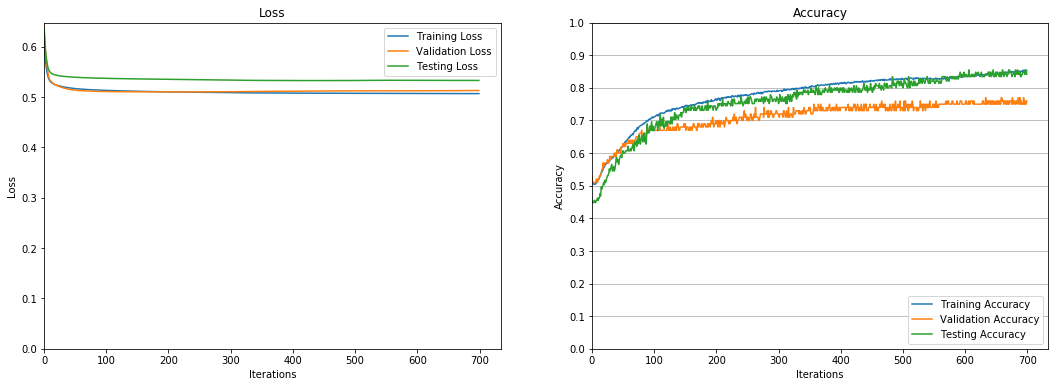

In [33]:
# 3.1.2 with Cross Entropy Loss
w, b, *statistics = SGD(trainData, trainTarget, 
                        alpha=0.001, 
                        epochs=700, 
                        reg=0,
                        lossType='CE',
                        batch_size=500,
                        **VTDatasets)
train_loss, train_acc, valid_loss, valid_acc, test_loss, test_acc = statistics

print(f"Training loss: {train_loss[-1]:.4f}{'':20s}Training acc: {train_acc[-1]*100:.2f}%")
print(f"Validation loss: {valid_loss[-1]:.4f}{'':18s}Validation acc: {valid_acc[-1]*100:.2f}%")
print(f"Testing loss: {test_loss[-1]:.4f}{'':21s}Testing acc: {test_acc[-1]*100:.2f}%")

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
plot_loss(np.arange(0, len(train_loss), 1), train_loss, valid_loss, test_loss, ax=ax[0])
plot_accuracy(np.arange(0, len(train_loss), 1), train_acc, valid_acc, test_acc, ax=ax[1])
plt.show()

beta1: 0.95	beta2: 0.99	epsilon: 1e-09
Training loss: 0.5064                    Training acc: 92.34%
Validation loss: 0.5129                  Validation acc: 85.00%
Testing loss: 0.5354                     Testing acc: 90.34%


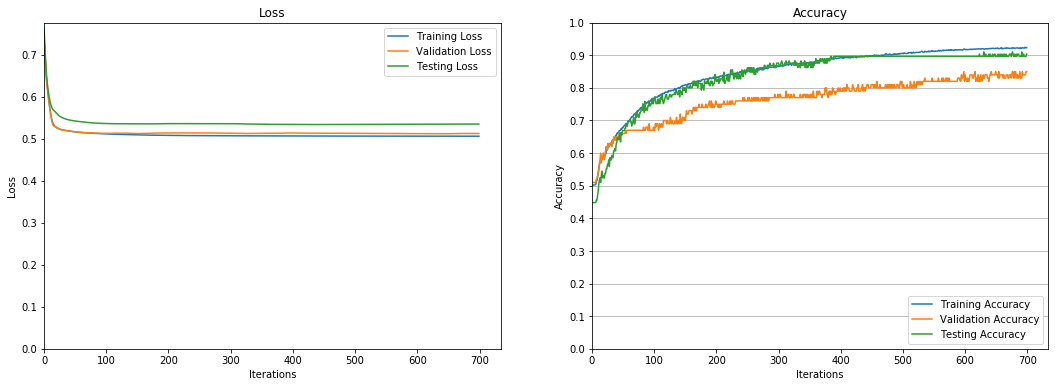

beta1: 0.95	beta2: 0.99	epsilon: 0.0001
Training loss: 0.5072                    Training acc: 87.91%
Validation loss: 0.5168                  Validation acc: 81.00%
Testing loss: 0.5328                     Testing acc: 86.90%


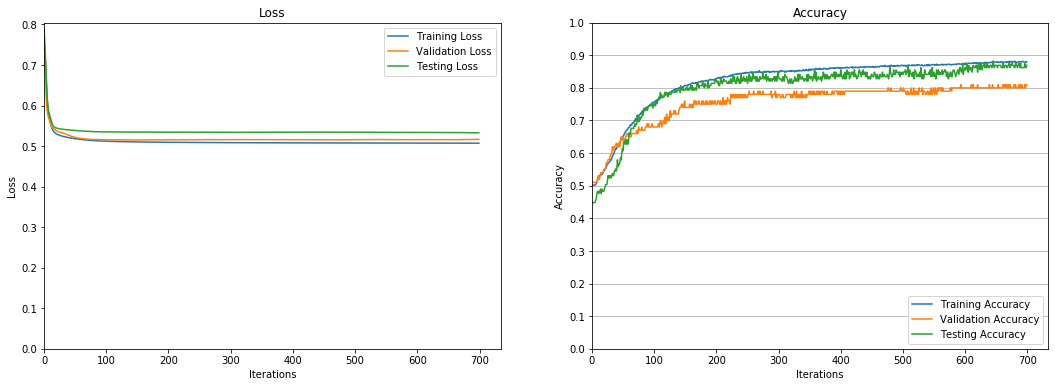

beta1: 0.95	beta2: 0.9999	epsilon: 1e-09
Training loss: 0.5090                    Training acc: 81.97%
Validation loss: 0.5127                  Validation acc: 75.00%
Testing loss: 0.5385                     Testing acc: 82.76%


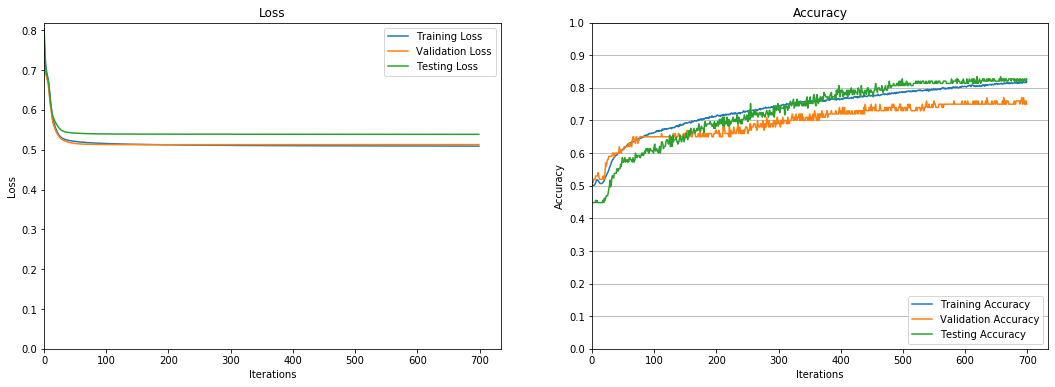

beta1: 0.95	beta2: 0.9999	epsilon: 0.0001
Training loss: 0.5086                    Training acc: 80.89%
Validation loss: 0.5067                  Validation acc: 76.00%
Testing loss: 0.5349                     Testing acc: 79.31%


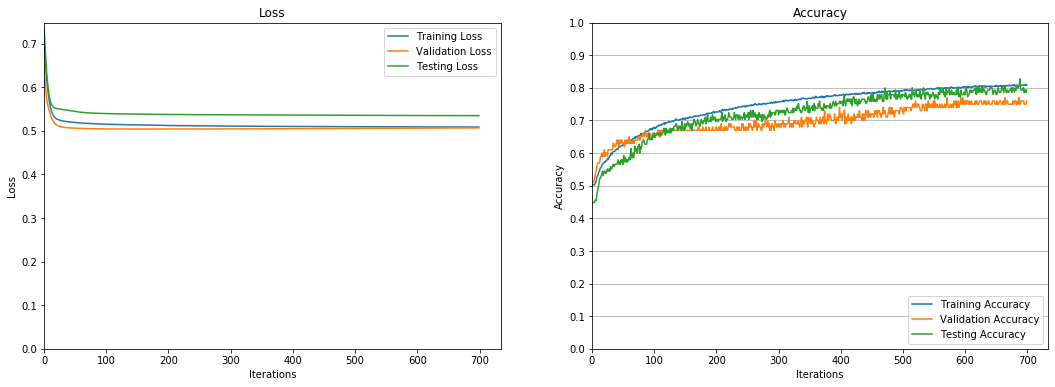

beta1: 0.99	beta2: 0.99	epsilon: 1e-09
Training loss: 0.5073                    Training acc: 94.03%
Validation loss: 0.5123                  Validation acc: 87.00%
Testing loss: 0.5333                     Testing acc: 94.48%


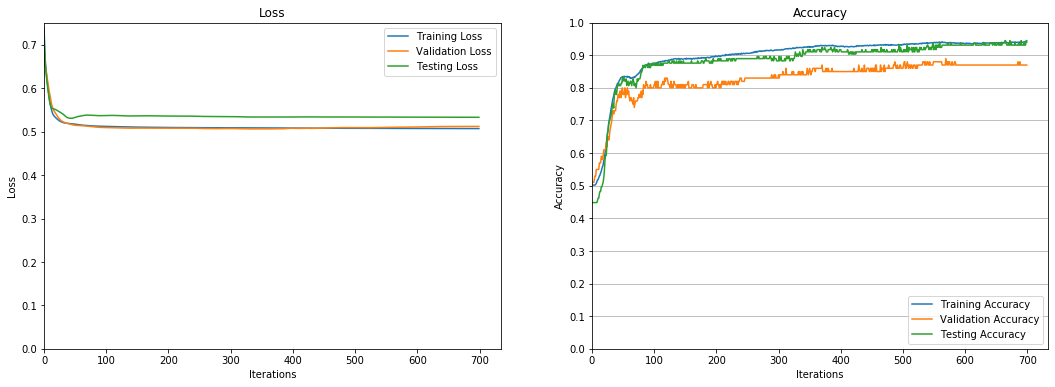

beta1: 0.99	beta2: 0.99	epsilon: 0.0001
Training loss: 0.5085                    Training acc: 91.54%
Validation loss: 0.5160                  Validation acc: 82.00%
Testing loss: 0.5361                     Testing acc: 90.34%


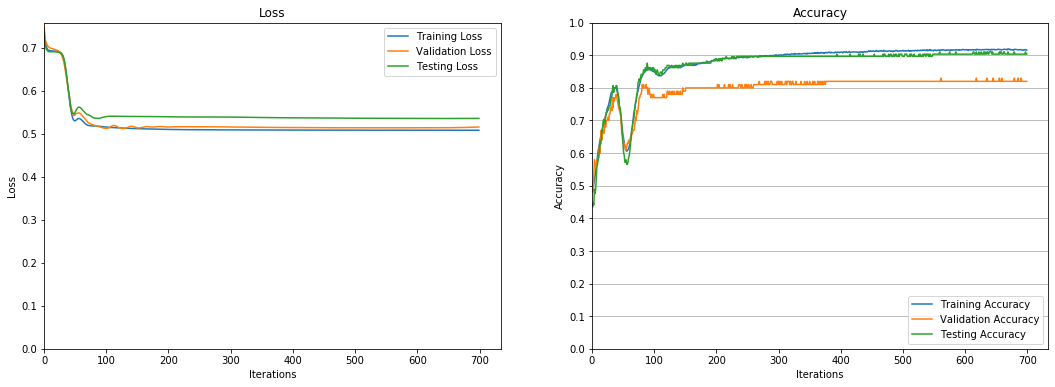

beta1: 0.99	beta2: 0.9999	epsilon: 1e-09
Training loss: 0.5077                    Training acc: 85.94%
Validation loss: 0.5044                  Validation acc: 76.00%
Testing loss: 0.5346                     Testing acc: 85.52%


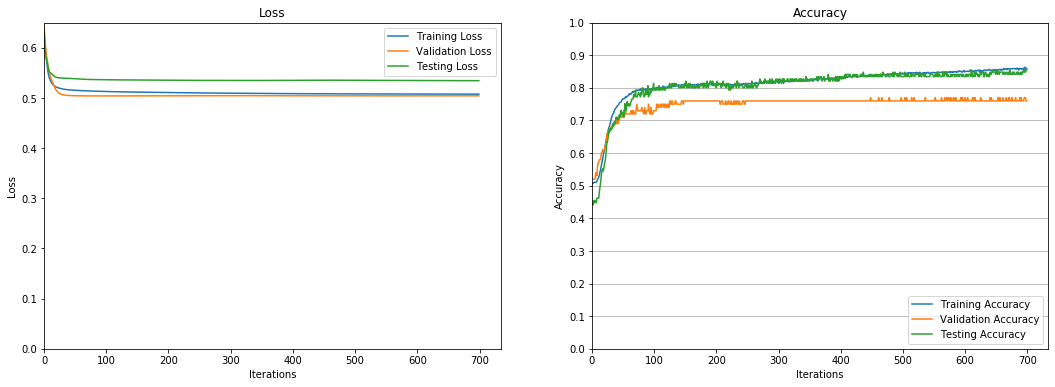

beta1: 0.99	beta2: 0.9999	epsilon: 0.0001
Training loss: 0.5088                    Training acc: 83.89%
Validation loss: 0.5083                  Validation acc: 75.00%
Testing loss: 0.5341                     Testing acc: 84.14%


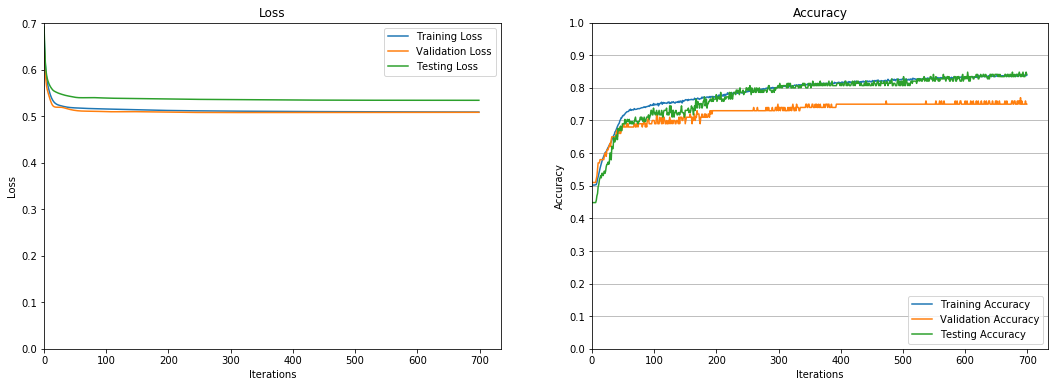

In [34]:
# 3.1.4 with Cross Entropy Loss
for beta1 in [0.95, 0.99]:
    for beta2 in [0.99, 0.9999]:
        for epsilon in [1e-9, 1e-4]:
            
            print(f"beta1: {beta1}\tbeta2: {beta2}\tepsilon: {epsilon}")
            
            w, b, *statistics = SGD(trainData, trainTarget, 
                                    alpha=0.001, 
                                    epochs=700, 
                                    reg=0,
                                    lossType='CE',
                                    batch_size=500,
                                    beta1=beta1, beta2=beta2, epsilon=epsilon,
                                    **VTDatasets)
            
            train_loss, train_acc, valid_loss, valid_acc, test_loss, test_acc = statistics
    
            print(f"Training loss: {train_loss[-1]:.4f}{'':20s}Training acc: {train_acc[-1]*100:.2f}%")
            print(f"Validation loss: {valid_loss[-1]:.4f}{'':18s}Validation acc: {valid_acc[-1]*100:.2f}%")
            print(f"Testing loss: {test_loss[-1]:.4f}{'':21s}Testing acc: {test_acc[-1]*100:.2f}%")

            fig, ax = plt.subplots(1, 2, figsize=(18, 6))
            plot_loss(np.arange(0, len(train_loss), 1), train_loss, valid_loss, test_loss, ax=ax[0])
            plot_accuracy(np.arange(0, len(train_loss), 1), train_acc, valid_acc, test_acc, ax=ax[1])
            plt.show()
            plt.close()

### 6. Comparison against Batch GD

One of the big differences between the SGD with Adam and batch gradient descent is how much quicker SGD is able to achieve the same results as BGD. BGD usually required 1000 epochs at minimum to stabilize the curves. SGD, on the other hand, was able to do so in less than 200 epochs. 

Concerning the accuracy plots, SGD with Adam creates creates an oscillating curve in most cases, before smoothing out. BGD, on the other hand, maintains a smooth curve throughout the training. This is most likely due to the nature of SGD working in random mini batches. As the algorithm finishes training on one mini batch, the accuracy is high. With the next random batch, however, the initial results are poor and the model needs to "retrain". This produces the oscillation in the curve. 
The loss graphs mirror this behaviour as well, with some of the loss graphs oscillating with the accuracy.